<a href="https://colab.research.google.com/github/smnawfee/Exploring-Urban-Place-Function-through-User-Generated-Textual-Content/blob/main/combination__wiki%2Bosm_kc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 712.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.2 MB/s eta 0:00:00


Load libraries

In [ ]:
#from bertopic import BERTopic
import io
from google.colab import files
import pandas as pd
import geopandas as gpd
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

#Loading Data and merge them

In [ ]:
osm_uploaded = files.upload()
wiki_uploaded = files.upload()

Saving kc_osm_data2.csv to kc_osm_data2.csv


Saving kc_wiki_with_summary.csv to kc_wiki_with_summary.csv


In [ ]:
#read file
kc_wiki= pd.read_csv(io.BytesIO(wiki_uploaded['kc_wiki_with_summary.csv']))
kc_osm = pd.read_csv(io.BytesIO(osm_uploaded['kc_osm_data2.csv']), index_col=0)
#convert osm data to geopandas dataframe
import shapely.wkt
kc_osm['geometry.coordinates'] = gpd.GeoSeries.from_wkt(kc_osm["geometry.coordinates"])
kc_osm = gpd.GeoDataFrame(kc_osm, geometry = 'geometry.coordinates',
                                  crs="EPSG:4326")
kc_osm = kc_osm.rename(columns={'geometry.coordinates': 'geometry'})
#select certain columns from wiki data
kc_wiki = kc_wiki[["gt_page_id",
                   "gt_lon",
                   "gt_lat",
                   "geometry",
                   "page_title",
                   "page_summary"]]
#set geometry for wiki data
kc_wiki = gpd.GeoDataFrame(kc_wiki,
                           geometry=gpd.points_from_xy(kc_wiki.gt_lon,
                                                       kc_wiki.gt_lat),
                                                       crs="EPSG:4326")
#join dataframes
osm_wiki_kc = pd.concat([kc_osm, kc_wiki], ignore_index=True, sort=False)

In [ ]:
#remove duplicates
osm_wiki_kc = osm_wiki_kc.drop_duplicates(subset=['geometry'])
osm_wiki_kc

,geometry,properties.@osmId,key,value,gt_page_id,gt_lon,gt_lat,page_title,page_summary
0,POINT (-0.19315 51.50024),node/376496924,properties.amenity,post_box,NaN,NaN,NaN,NaN,NaN
1,POINT (-0.19301 51.49998),node/1291086772,properties.amenity,parking_entrance,NaN,NaN,NaN,NaN,NaN
2,POINT (-0.19332 51.50046),node/1291086833,properties.amenity,dentist,NaN,NaN,NaN,NaN,NaN
3,POINT (-0.19339 51.50059),node/1291086846,properties.amenity,dentist,NaN,NaN,NaN,NaN,NaN
4,POINT (-0.19461 51.49741),node/376497068,properties.amenity,post_box,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
6558,POINT (-0.20018 51.49986),NaN,NaN,NaN,1619245.0,-0.200180,51.499860,Commonwealth_Institute,The Commonwealth Education Trust is a regist...
6559,POINT (-0.2043 51.5096),NaN,NaN,NaN,94200.0,-0.204300,51.509600,Notting_Hill,"Notting Hill is a district of West London, Eng..."
6560,POINT (-0.162 51.484),NaN,NaN,NaN,1702541.0,-0.162000,51.484000,Chelsea_Embankment,Chelsea Embankment is part of the Thames Emban...
6561,POINT (-0.17194 51.49667),NaN,NaN,NaN,1703553.0,-0.171944,51.496667,Gilbert_Collection,The Rosalinde and Arthur Gilbert Collection is...


Perform DBSCAN for a combined dataset of osm and wiki

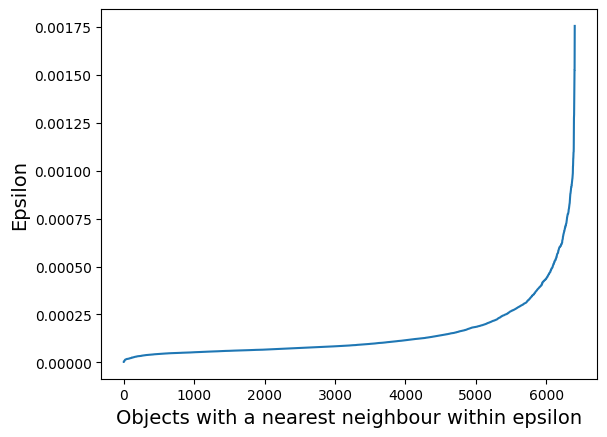

In [ ]:
from shapely.geometry import MultiPoint
osm_wiki_kc['lon'] = osm_wiki_kc['geometry'].x
osm_wiki_kc['lat'] = osm_wiki_kc['geometry'].y
kc_coords = osm_wiki_kc[['lon', 'lat']].to_numpy()
#finding the optimum epsilon
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(kc_coords)
distances, indices = neighbors_fit.kneighbors(kc_coords)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.xlabel('Objects with a nearest neighbour within epsilon', fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.plot(distances)

no. of clusters: 144
no of noise: 366


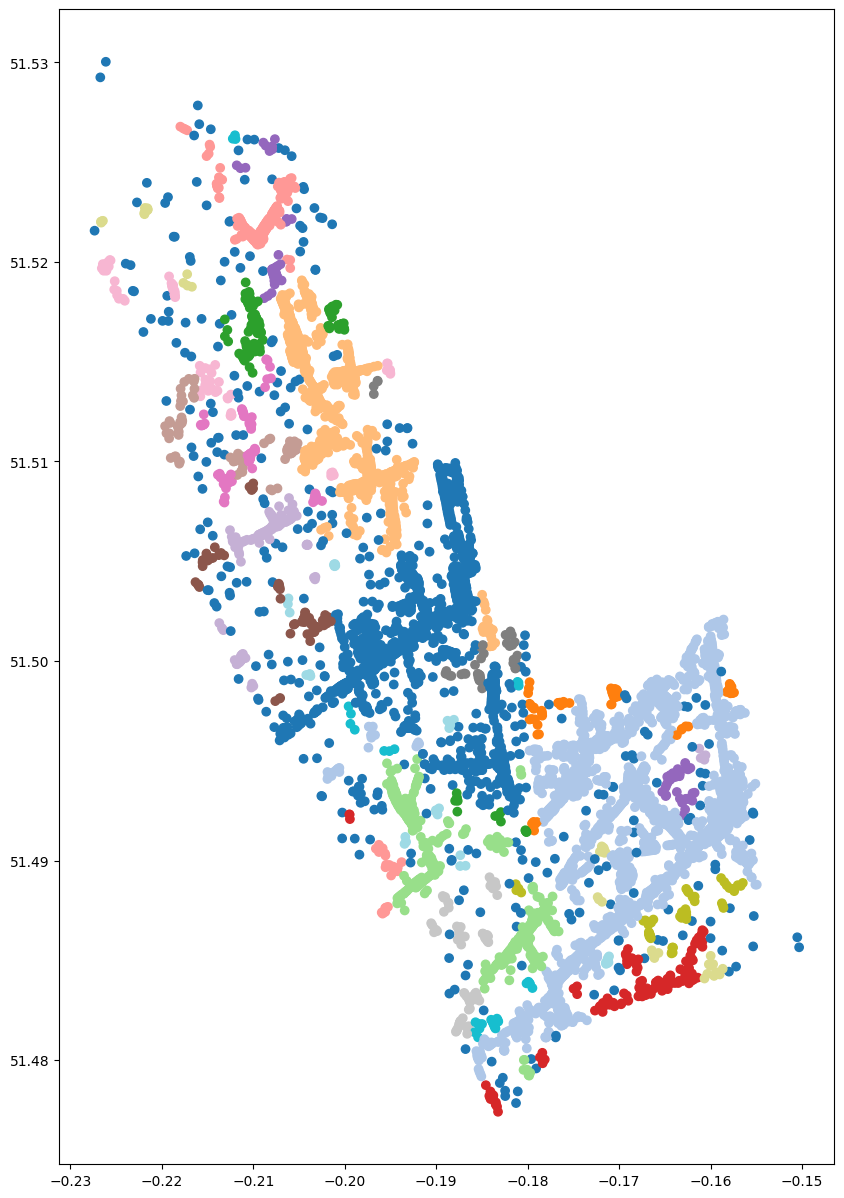

In [ ]:
#run dbscan
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
#run dbscan clustering
dbscan = DBSCAN(eps=0.0006, min_samples=3)
kc_dbscan = dbscan.fit(kc_coords)
#get the labels of clustering
dbscan_labels = kc_dbscan.labels_
dbscan_labels
print('no. of clusters:', len(np.unique(dbscan_labels)))
print('no of noise:', np.sum(np.array(dbscan_labels) == -1, axis=0))
#add cluster labels to dataset
osm_wiki_kc['cluster'] = dbscan_labels

import matplotlib.pyplot as plt
#plot dbscan
plt.figure(figsize=(10, 15))
plt.scatter(osm_wiki_kc['lon'],
            osm_wiki_kc['lat'],
            c=osm_wiki_kc['cluster'],
            cmap='tab20')


plt.show()

Get tag list for each dbscan cluster as a list

In [ ]:
#for OSM
osm_kc_dbscan_only = osm_wiki_kc.dropna(subset=['value'])
osm_kc_dbscan_new = pd.DataFrame(osm_kc_dbscan_only.groupby('cluster')['value'].apply(list))
#for wiki
wiki_kc_dbscan_only = osm_wiki_kc.dropna(subset=['page_title'])

Regionalization

[<POLYGON ((-0.203 51.497, -0.201 51.502, -0.19 51.51, -0.188 51.51, -0.188 5...>, <POLYGON ((-0.196 51.498, -0.196 51.498, -0.196 51.498, -0.196 51.498))>, <POLYGON ((-0.205 51.497, -0.205 51.497, -0.205 51.497, -0.205 51.497, -0.20...>, <POLYGON ((-0.207 51.496, -0.207 51.496, -0.207 51.497, -0.206 51.497, -0.20...>, <POLYGON ((-0.194 51.496, -0.193 51.498, -0.193 51.498, -0.192 51.497, -0.19...>, <POLYGON ((-0.182 51.492, -0.185 51.493, -0.187 51.493, -0.191 51.495, -0.19...>, <POLYGON ((-0.198 51.493, -0.199 51.493, -0.198 51.494, -0.198 51.493, -0.19...>, <POLYGON ((-0.202 51.494, -0.202 51.494, -0.201 51.495, -0.201 51.494, -0.20...>, <POLYGON ((-0.197 51.496, -0.197 51.497, -0.197 51.497, -0.197 51.496, -0.19...>, <POLYGON ((-0.192 51.496, -0.192 51.496, -0.192 51.496, -0.192 51.496, -0.19...>, <POLYGON ((-0.185 51.479, -0.185 51.479, -0.185 51.48, -0.186 51.48, -0.174 ...>, <POLYGON ((-0.178 51.492, -0.18 51.496, -0.174 51.498, -0.166 51.499, -0.165...>, <POLYGON ((-0.178 51.49

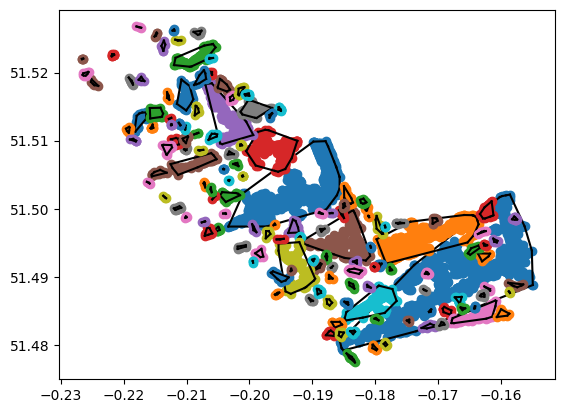

In [ ]:
#create convex hull
#Reference https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html
import scipy
import numpy
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt

#select only necessary column
db_cl = osm_wiki_kc[["lon",
                   "lat",
                   "cluster"]]
#remove noise
remove = db_cl[db_cl['cluster'] == -1].index
db_cl = db_cl.drop(remove)

#run convexhull for each clusters seperately
#create a list of convex hull
h = [] #for list of polygon coordinates from chull
for i in range(0,143):
    cluster_i = db_cl.loc[db_cl['cluster']==i]
    db_cl_i = cluster_i[["lon", "lat"]].to_numpy()
    ch_i = ConvexHull(db_cl_i)
    h.append(db_cl_i[ch_i.vertices,:].tolist())
    plt.plot(db_cl_i[:, 0],db_cl_i[:, 1],  'o')
    for simplex in ch_i.simplices:
        ploted=plt.plot(db_cl_i[simplex, 0], db_cl_i[simplex, 1],'k-')

from shapely.geometry import MultiPoint
c_h = []
for hull in h:
    c_h.append(MultiPoint(hull).convex_hull)

print(c_h)



Import BTM topics for OSM

In [ ]:
#import btm topics from osm_kc
osm_btm_uploaded = files.upload()


Saving osm_kc_btm_oct.csv to osm_kc_btm_oct.csv


In [ ]:
osm_btm= pd.read_csv(io.BytesIO(osm_btm_uploaded['osm_kc_btm_oct.csv']))
#osm_btm= pd.read_csv(io.BytesIO(osm_btm_uploaded['osm_kc_btm_topics.csv']))

In [ ]:
#Name the btm topics
def get_osm_topic_name(topic):
    if topic == 'V1':
        return 'Local Shopping Street'
    elif topic == 'V2':
        return 'Vehicle parking'
    elif topic == 'V3':
        return 'Antiques, Clothes and Fashion stores'
    elif topic == 'V4':
        return 'Commercial services and Diplomatic mission'
    elif topic == 'V5':
        return 'Restaurant, Cafe and Food shops'
    elif topic == 'V6':
        return 'Sports facilities, Gallery & Artwork'
    elif topic == 'V7':
        return 'Urban furniture'
    elif topic == 'V8':
        return 'Park and Green spaces'
    elif topic == 'V9':
        return 'Vehicle parking'
    else:
        return 'Healthcare facilities'

In [ ]:
osm_btm['Topic_Name_OSM'] = osm_btm['Topic'].apply(get_osm_topic_name)

In [ ]:
#merge
kc_osm =  pd.merge(osm_kc_dbscan_only, osm_btm, on = 'cluster')

In [ ]:
#kc_osm.to_csv('osm_btm_with_topic_names.csv')
#files.download('osm_btm_with_topic_names.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#join dataframes
osm_btm_wiki = pd.concat([kc_osm, wiki_kc_dbscan_only], ignore_index=True, sort=False)
osm_btm_wiki

,geometry,properties.@osmId,key,value,gt_page_id,gt_lon,gt_lat,page_title,page_summary,lon,...,V3,V4,V5,V6,V7,V8,V9,V10,Topic,Topic_Name_OSM
0,POINT (-0.19315 51.50024),node/376496924,properties.amenity,post_box,NaN,NaN,NaN,NaN,NaN,-0.193151,...,0.059091,0.039478,0.166618,0.034284,0.020991,0.257689,0.131595,0.027609,V8,Park and Green spaces
1,POINT (-0.19301 51.49998),node/1291086772,properties.amenity,parking_entrance,NaN,NaN,NaN,NaN,NaN,-0.193006,...,0.059091,0.039478,0.166618,0.034284,0.020991,0.257689,0.131595,0.027609,V8,Park and Green spaces
2,POINT (-0.19332 51.50046),node/1291086833,properties.amenity,dentist,NaN,NaN,NaN,NaN,NaN,-0.193320,...,0.059091,0.039478,0.166618,0.034284,0.020991,0.257689,0.131595,0.027609,V8,Park and Green spaces
3,POINT (-0.19339 51.50059),node/1291086846,properties.amenity,dentist,NaN,NaN,NaN,NaN,NaN,-0.193388,...,0.059091,0.039478,0.166618,0.034284,0.020991,0.257689,0.131595,0.027609,V8,Park and Green spaces
4,POINT (-0.19461 51.49741),node/376497068,properties.amenity,post_box,NaN,NaN,NaN,NaN,NaN,-0.194611,...,0.005855,0.019403,0.186046,0.034740,0.133122,0.010989,0.533567,0.028146,V9,Vehicle parking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6403,POINT (-0.20018 51.49986),NaN,NaN,NaN,1619245.0,-0.200180,51.499860,Commonwealth_Institute,The Commonwealth Education Trust is a regist...,-0.200180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6404,POINT (-0.2043 51.5096),NaN,NaN,NaN,94200.0,-0.204300,51.509600,Notting_Hill,"Notting Hill is a district of West London, Eng...",-0.204300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6405,POINT (-0.162 51.484),NaN,NaN,NaN,1702541.0,-0.162000,51.484000,Chelsea_Embankment,Chelsea Embankment is part of the Thames Emban...,-0.162000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6406,POINT (-0.17194 51.49667),NaN,NaN,NaN,1703553.0,-0.171944,51.496667,Gilbert_Collection,The Rosalinde and Arthur Gilbert Collection is...,-0.171944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Run Bertopic on wiki summary

In [ ]:
#extract only wiki data first
summary_kc = kc_wiki['page_summary'].tolist()
#run model
#extract embeddings
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
#reduce dimension
from umap import UMAP
umap_model = UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='cosine')
#clustering
from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size = 4, min_samples = 3,
                        gen_min_span_tree = True,
                        prediction_data = True)

#Tokenize topics
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words="english")
# Create topic representation
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer()
topic_model = BERTopic( embedding_model=embedding_model,
                        umap_model=umap_model,
                        hdbscan_model=hdbscan_model,
                        vectorizer_model=cv,
                        ctfidf_model=ctfidf_model,
                        nr_topics=8,
                        language="english",
                        calculate_probabilities=True,
                        verbose=True)
topics, probs = topic_model.fit_transform(summary_kc)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-11-12 17:30:29,218 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2024-11-12 17:30:46,624 - BERTopic - Embedding - Completed ✓
2024-11-12 17:30:46,628 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-12 17:30:58,149 - BERTopic - Dimensionality - Completed ✓
2024-11-12 17:30:58,152 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-12 17:30:58,221 - BERTopic - Cluster - Completed ✓
2024-11-12 17:30:58,223 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-12 17:30:58,328 - BERTopic - Representation - Completed ✓
2024-11-12 17:30:58,330 - BERTopic - Topic reduction - Reducing number of topics
2024-11-12 17:30:58,390 - BERTopic - Topic reduction - Reduced number of topics from 29 to 8


In [ ]:
topic_wiki = pd.DataFrame(topic_model.get_document_info(summary_kc))
topic_model.visualize_barchart(top_n_topics = 8)

In [ ]:
topic_model.generate_topic_labels()

['-1_school_house_kensington',
 '0_london_street_kensington',
 '1_embassy_kingdom_diplomatic',
 '2_boutique_shop_hendrix',
 '3_museum_science_victoria',
 '4_school_academy_education',
 '5_restaurant_michelin_indian',
 '6_gallery_art_collection']

In [ ]:
def get_topic_name(topic):
    if topic == 0:
        return 'Renowned roads and streets'
    elif topic == - 1:
        return 'Mixed'
    elif topic == 1:
        return 'Embassy and Diplomatic zone'
    elif topic == 2:
        return 'Boutique and fashion store'
    elif topic == 3:
        return 'Museum and Exhibition'
    elif topic == 4:
        return 'Educational institutes'
    elif topic == 5:
        return 'Restaurant, Cafe and Food shops'
    else:
        return 'Mixed'

In [ ]:
topic_wiki['Topic_Name_Wiki'] = topic_wiki['Topic'].apply(get_topic_name)

In [ ]:
# Merge wiki topic by index
kc_wiki_topic = pd.merge(kc_wiki, topic_wiki, left_index=True, right_index=True)
kc_wiki_topic = gpd.GeoDataFrame(kc_wiki_topic, geometry = kc_wiki_topic["geometry"])

Integrate two topic type

In [ ]:
#merge with osm_btm and wiki_bertopic
#merged_gdf = gpd.sjoin(osm_wiki_kc, kc_wiki_topic, how="left")
osm_btm_wiki = gpd.GeoDataFrame(osm_btm_wiki, geometry = osm_btm_wiki["geometry"])
merged_gdf = gpd.sjoin(osm_btm_wiki, kc_wiki_topic, how="left")
list(merged_gdf)
#select certain columns from wiki data
merged_gdf_fil = merged_gdf[[
                   "geometry",
                   "lon",
                   "lat",
                   "Topic_Name_OSM",
                   "Topic_Name_Wiki",
                   "cluster"]]
merged_gdf_fil

,geometry,lon,lat,Topic_Name_OSM,Topic_Name_Wiki,cluster
0,POINT (-0.19315 51.50024),-0.193151,51.500241,Park and Green spaces,NaN,0
1,POINT (-0.19301 51.49998),-0.193006,51.499975,Park and Green spaces,NaN,0
2,POINT (-0.19332 51.50046),-0.193320,51.500461,Park and Green spaces,NaN,0
3,POINT (-0.19339 51.50059),-0.193388,51.500591,Park and Green spaces,NaN,0
4,POINT (-0.19461 51.49741),-0.194611,51.497411,Vehicle parking,NaN,-1
...,...,...,...,...,...,...
6403,POINT (-0.20018 51.49986),-0.200180,51.499860,NaN,Educational institutes,0
6404,POINT (-0.2043 51.5096),-0.204300,51.509600,NaN,Renowned roads and streets,24
6405,POINT (-0.162 51.484),-0.162000,51.484000,NaN,Renowned roads and streets,46
6406,POINT (-0.17194 51.49667),-0.171944,51.496667,NaN,Mixed,11


In [ ]:
#remove the noise cluster
remove = merged_gdf_fil[merged_gdf_fil['cluster'] == -1].index
merged_gdf_fil = merged_gdf_fil.drop(remove)

In [ ]:
#Create one column for topic label
merged_gdf_fil['Topic'] = merged_gdf_fil['Topic_Name_OSM'].where(merged_gdf_fil['Topic_Name_Wiki'].isna(),
                                                                 merged_gdf_fil['Topic_Name_Wiki'])

merged_gdf_fil

,geometry,lon,lat,Topic_Name_OSM,Topic_Name_Wiki,cluster,Topic
0,POINT (-0.19315 51.50024),-0.193151,51.500241,Park and Green spaces,NaN,0,Park and Green spaces
1,POINT (-0.19301 51.49998),-0.193006,51.499975,Park and Green spaces,NaN,0,Park and Green spaces
2,POINT (-0.19332 51.50046),-0.193320,51.500461,Park and Green spaces,NaN,0,Park and Green spaces
3,POINT (-0.19339 51.50059),-0.193388,51.500591,Park and Green spaces,NaN,0,Park and Green spaces
5,POINT (-0.19659 51.49836),-0.196594,51.498362,Park and Green spaces,NaN,0,Park and Green spaces
...,...,...,...,...,...,...,...
6402,POINT (-0.20208 51.50225),-0.202078,51.502253,NaN,Renowned roads and streets,72,Renowned roads and streets
6403,POINT (-0.20018 51.49986),-0.200180,51.499860,NaN,Educational institutes,0,Educational institutes
6404,POINT (-0.2043 51.5096),-0.204300,51.509600,NaN,Renowned roads and streets,24,Renowned roads and streets
6405,POINT (-0.162 51.484),-0.162000,51.484000,NaN,Renowned roads and streets,46,Renowned roads and streets


Organise clusters based on number of each OSM_BTM topics and Wiki BERTopic

In [ ]:
#pivot osm tags
merged_gdf3 = (
    pd.melt(merged_gdf_fil,
            id_vars=['cluster'],
            value_vars = ['Topic'])
      .pivot_table(columns='value',
                    aggfunc='count',
                    index='cluster',
                    values='value',
                    fill_value=0)
       )
merged_gdf3.columns.name = None
merged_gdf3

,"Antiques, Clothes and Fashion stores",Boutique and fashion store,Commercial services and Diplomatic mission,Educational institutes,Embassy and Diplomatic zone,Healthcare facilities,Local Shopping Street,Mixed,Museum and Exhibition,Park and Green spaces,Renowned roads and streets,"Restaurant, Cafe and Food shops","Sports facilities, Gallery & Artwork",Urban furniture,Vehicle parking
cluster,,,,,,,,,,,,,,,
0,0,1,0,1,0,0,0,5,1,911,17,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0
139,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0
140,0,0,0,0,0,0,0,1,0,8,0,0,0,0,0


In [ ]:
#summary stat for each column
merged_gdf3.describe()

,"Antiques, Clothes and Fashion stores",Boutique and fashion store,Commercial services and Diplomatic mission,Educational institutes,Embassy and Diplomatic zone,Healthcare facilities,Local Shopping Street,Mixed,Museum and Exhibition,Park and Green spaces,Renowned roads and streets,"Restaurant, Cafe and Food shops","Sports facilities, Gallery & Artwork",Urban furniture,Vehicle parking
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,5.524476,0.090909,0.272727,0.125874,0.104895,0.468531,0.090909,0.209790,0.104895,6.825175,0.755245,11.713287,0.020979,0.335664,15.678322
std,34.193697,0.568035,1.972279,0.501647,0.423155,2.399543,1.087115,0.767777,0.861650,76.176344,2.635662,60.229096,0.250873,1.631314,121.253407
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,7.000000
max,352.000000,5.000000,22.000000,4.000000,3.000000,17.000000,13.000000,7.000000,10.000000,911.000000,26.000000,550.000000,3.000000,15.000000,1450.000000


In [ ]:
#standardise data
from sklearn.preprocessing import StandardScaler
sca = StandardScaler()
cow_std = sca.fit_transform(merged_gdf3)
from sklearn.decomposition import PCA
#check for optimum number of components
#ref https://www.kdnuggets.com/2023/05/principal-component-analysis-pca-scikitlearn.html
import numpy as np
nums = np.arange(16)
variance_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit_transform(cow_std)
  variance_ratio.append(np.sum(pca.explained_variance_ratio_))


Text(0, 0.5, 'Explained variance ratio')

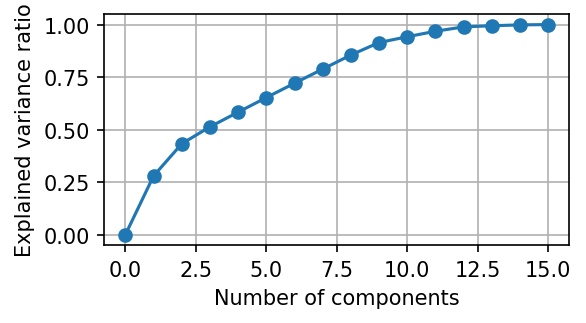

In [ ]:
#plot variance ratio for different component size
import matplotlib.pyplot as plt
plt.figure(figsize=(4,2),dpi=150)
plt.grid()
plt.plot(nums,variance_ratio,marker='o')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
#plt.title('No. of components vs. Explained Variance Ratio')

In [ ]:
#dimension reduction
pca = PCA(n_components=12)
cow_dr = pd.DataFrame(pca.fit_transform(cow_std))

Run clustering on the resultant dataset

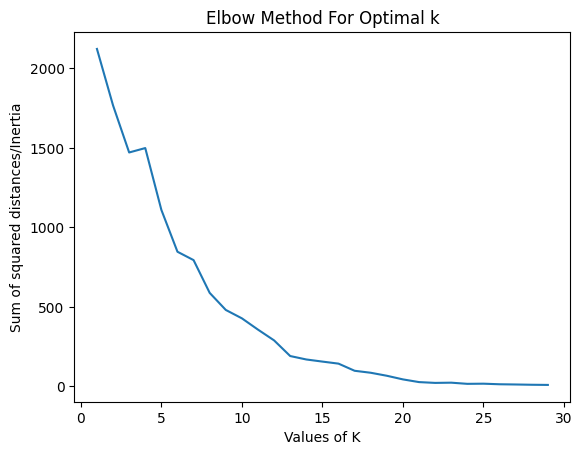

In [ ]:
x_array = cow_dr.values.tolist()
#determine optimum number of k for k-means clustering
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
Sum_of_squared_distances = []
K = range(1,30)
for cluster_no in K :
 kmeans = KMeans(n_clusters=cluster_no)
 kmeans.fit(x_array)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances)
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances/Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
#run k-means
kmeans2 = KMeans(n_clusters=12, random_state=0).fit(x_array)
label = kmeans2.fit_predict(x_array)
#join the cluster label to each dbscan cluster
import numpy as np
merged_gdf3['k_means_cluster'] = np.array(label)
merged_gdf3

,"Antiques, Clothes and Fashion stores",Boutique and fashion store,Commercial services and Diplomatic mission,Educational institutes,Embassy and Diplomatic zone,Healthcare facilities,Local Shopping Street,Mixed,Museum and Exhibition,Park and Green spaces,Renowned roads and streets,"Restaurant, Cafe and Food shops","Sports facilities, Gallery & Artwork",Urban furniture,Vehicle parking,k_means_cluster
cluster,,,,,,,,,,,,,,,,
0,0,1,0,1,0,0,0,5,1,911,17,1,0,0,0,4
1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,11
139,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0
140,0,0,0,0,0,0,0,1,0,8,0,0,0,0,0,0


Visualize k-clusters (spatial and non-spatial)

Heatmap Visualisation

In [ ]:
import pandas as pd
K_clusters = merged_gdf3.pivot_table(
                            index= 'k_means_cluster',
                            aggfunc="sum")

In [ ]:
K_clusters

,"Antiques, Clothes and Fashion stores",Boutique and fashion store,Commercial services and Diplomatic mission,Educational institutes,Embassy and Diplomatic zone,Healthcare facilities,Local Shopping Street,Mixed,Museum and Exhibition,Park and Green spaces,Renowned roads and streets,"Restaurant, Cafe and Food shops","Sports facilities, Gallery & Artwork",Urban furniture,Vehicle parking
k_means_cluster,,,,,,,,,,,,,,,
0,438,2,17,0,4,20,0,10,1,65,55,587,0,0,695
1,0,2,0,2,3,0,0,3,9,0,5,550,0,0,0
2,0,0,0,0,0,0,13,0,0,0,1,0,0,0,0
3,0,5,0,0,1,0,0,9,0,0,27,0,0,0,1450
4,0,1,0,1,0,0,0,5,1,911,17,1,0,0,0
5,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,1,0,3,0,0
7,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0
8,352,0,0,0,0,0,0,0,0,0,5,0,0,0,0


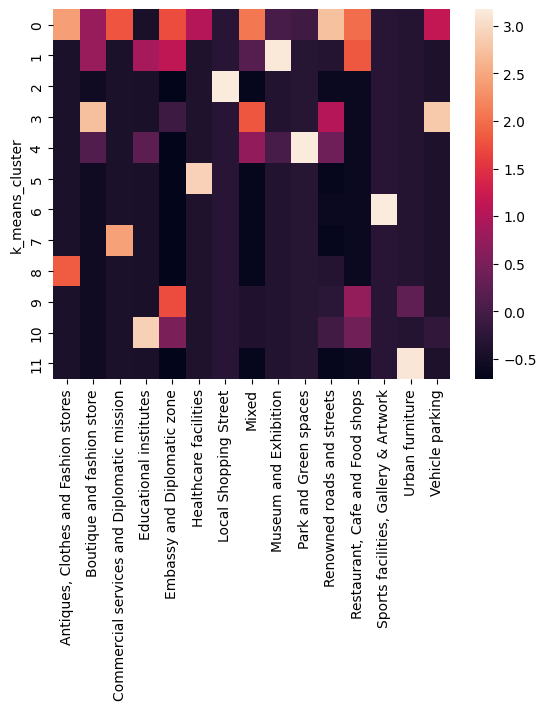

In [ ]:
#standardize data (z-score normalisation)
new_k_clusters = (K_clusters - K_clusters.mean())/K_clusters.std()
new_k_clusters
import seaborn as sns
k_heatmap = sns.heatmap(new_k_clusters)

In [ ]:
merged_gdf5 = pd.merge(merged_gdf3,
                       merged_gdf_fil.groupby('cluster')['geometry'].apply(list),
                       on = 'cluster')

,"Antiques, Clothes and Fashion stores",Boutique and fashion store,Commercial services and Diplomatic mission,Educational institutes,Embassy and Diplomatic zone,Healthcare facilities,Local Shopping Street,Mixed,Museum and Exhibition,Park and Green spaces,Renowned roads and streets,"Restaurant, Cafe and Food shops","Sports facilities, Gallery & Artwork",Urban furniture,Vehicle parking,k_means_cluster,geometry
cluster,,,,,,,,,,,,,,,,,
0,0,1,0,1,0,0,0,5,1,911,17,1,0,0,0,4,"[POINT (-0.1931507 51.5002406), POINT (-0.1930..."
1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,"[POINT (-0.196173 51.4975787), POINT (-0.19589..."
2,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,"[POINT (-0.2052432 51.4966829), POINT (-0.2051..."
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,"[POINT (-0.2071145 51.4960212), POINT (-0.2067..."
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,27,0,"[POINT (-0.1923957 51.4966249), POINT (-0.1925..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,11,"[POINT (-0.2011653 51.504841), POINT (-0.20114..."
139,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,"[POINT (-0.1898503 51.4923066), POINT (-0.1899..."
140,0,0,0,0,0,0,0,1,0,8,0,0,0,0,0,0,"[POINT (-0.1714626 51.4848766), POINT (-0.1714..."


In [ ]:
cluster_info = merged_gdf3[['k_means_cluster']]

In [ ]:
##add c_h polygon coordinates
cluster_info['geometry'] = c_h
#set index as column
cluster_info['cluster'] = cluster_info.index